# **NONLINEAR ANALYSIS OF A SHALLOW TRUSS**
***

<img src="img/shallow_truss_0.jpg" width=350 height=250 /> 
<img src="img/shallow_truss_1.jpg" width=250 height=125 />

In [2]:
from numpy import sqrt
from scipy.optimize import newton, minimize
import matplotlib.pyplot as plt

In [3]:
# Units are understood in [kN] and [m]
b = 10.  # half of the total width of the structure in [m]
h = 0.5  # initial height of the structure in [m]
EA = 5000.  # <Young's modulus> * <Cross sectional area> in [kN/m2]
k = 1.0  # spring stiffness [kN/m]
F = 1.5  # applied load in [kN]
v = 0.  # initial guess of the displacement in [m]

## **EQUILIBRIUM APPROACH**

We use the equilibrium equations to create two residual functions, one for force-controlled and another for displacement-controlled calculations.

### §**FORCE-CONTROL**

The first one looks like:
$$
R(v) = F - k v + K \left( l(v)-l_0 \right) \frac{h-v}{l(v)}
$$

We also make a version of this with the approximation $l(v) \approx l0$, so that we can observe it's validity on our problem.

In [4]:
def R(F):
    """
    Returns the residual function R(v). 
    Optimal for a force-controlled analysis, 
    where this function is called in succession 
    for different (probably increasing) load values.
    """
    l0 = sqrt(h**2 + b**2)
    def inner(v):
        l = sqrt((h-v)**2 + b**2)
        return F - k*v + EA*((l-l0)/l0)*((h-v)/l)
    return inner

def R_(F):
    """
    Returns the residual function R(v). 
    Optimal for a force-controlled analysis, 
    where this function is called in succession 
    for different (probably increasing) load values.
    This version assumes the validity of the 
    approximation |l < l0| << 1.
    """
    l0 = sqrt(h**2 + b**2)
    def inner(v):
        l = sqrt((h-v)**2 + b**2)
        return F - k*v + EA*((l-l0)/l0)*((h-v)/l0)
    return inner

We use `scipy.optimize.newton` to find the roots of our equations. It needs to be fed with a callable object and an initial guess for the result: 

In [5]:
# solution by findig roots of a nonlinear function
v = newton(R(F), 0)
print("A result of F = {} [kN] is the displacement v = {} [m].".format(F, v))
# solution by findig roots of a nonlinear function using the approximation l = l0
v = newton(R_(F), 0)
print("A result of F = {} [kN] is the displacement v = {} [m].".format(F, v))

A result of F = 1.5 [kN] is the displacement v = 1.1696187845864412 [m].
A result of F = 1.5 [kN] is the displacement v = 1.1695310638900063 [m].


We apply the force in small steps, and we execute the previous calculation. In every substep, the initial guess is the result of the last substep. We also plot the evolution of the force-displacement diagram using `matplotlib`.

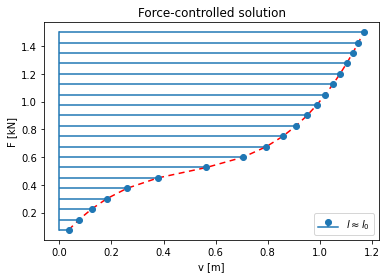

In [6]:
#k = 0.0
fig, ax = plt.subplots()
nstep = 20
ydata = [(i+1)*F/nstep for i in range(nstep)]
xdata, _xdata = [], []
v, _v = 0, 0
for Fi in ydata:
    v = newton(R(Fi), v)
    xdata.append(v)
    _v = newton(R_(Fi), _v)
    _xdata.append(_v)
ax.plot(xdata, ydata, dashes=[4, 3], color='red')
ax.stem(ydata, _xdata, label=r"$l \approx l_0$", basefmt='', orientation='horizontal')
ax.set_xlabel('v [m]')
ax.set_ylabel('F [kN]')
ax.legend()
ax.set_title('Force-controlled solution')
plt.show()

The figure shows that approximation $l \approx l0$ does not have a sigificant effect on the results of our model for this particular set of parameters. Try other parameters to investigate other possible scenarios.

### §**DISPLACEMENT-CONTROL**

The difference in the second function is that it considers the displacement to be known and the force to play the role of the unknown, but they basically evaluate the same expression:
$$
Q(F) = F - k v + K \left( l(v)-l_0 \right) \frac{h-v}{l(v)}
$$

Again, we can measure the effect of the approximation $l(v) \approx l0$.

In [7]:
def Q(v):
    """
    Returns the residual for a candidate solution. 
    Optimal for a displacement-controlled scenario.
    """
    l0 = sqrt(h**2 + b**2)
    def inner(F):
        l = sqrt((h-v)**2 + b**2)
        return F - k*v + EA*((l-l0)/l0)*((h-v)/l)
    return inner

def Q_(v):
    """
    Returns the residual for a candidate solution. 
    Optimal for a displacement-controlled scenario.
    """
    l0 = sqrt(h**2 + b**2)
    def inner(F):
        l = sqrt((h-v)**2 + b**2)
        return F - k*v + EA*((l-l0)/l0)*((h-v)/l0)
    return inner

To find the roots, we use the same facility:

In [8]:
# solution by findig roots of a nonlinear function
F = newton(Q(v), 0)
print("The reason of displacement v = {} [m] is the force F = {} [kN].".format(v, F))

The reason of displacement v = 1.169618784586734 [m] is the force F = 1.500000000001057 [kN].


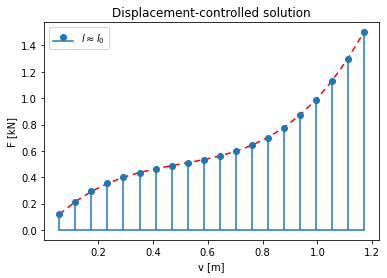

In [9]:
#k = 0.0
fig, ax = plt.subplots()
nstep = 20
xdata = [(i+1)*v/nstep for i in range(nstep)]
ydata, _ydata = [], []
F, _F = 0, 0
for vi in xdata:
    F = newton(Q(vi), F)
    ydata.append(F)
    _F = newton(Q_(vi), _F)
    _ydata.append(_F)
ax.plot(xdata, ydata, dashes=[4, 3], color='red')
ax.stem(xdata, _ydata, label=r"$l \approx l_0$", basefmt='')
ax.set_xlabel('v [m]')
ax.set_ylabel('F [kN]')
ax.legend()
ax.set_title('Displacement-controlled solution')
plt.show()

### §**ERROR MEASURE**

In [10]:
residual = R(F)
error = lambda x : residual(x[0])**2

In [11]:
# solution by minimizing an error measure
v = minimize(error, [0], method='Nelder-Mead', tol=1e-8).x[0]
print("A result of F = {} [kN] is the displacement v = {} [m].".format(F, v))

A result of F = 1.500000000001057 [kN] is the displacement v = 1.1696187820434583 [m].


## **ENERGY APPROACH**

In [12]:
def TPE(F):
    """
    Returns the residual for a candidate solution. 
    Optimal for a force-controlled scenario.
    """
    l0 = sqrt(h**2 + b**2)
    K = EA / l0
    def inner(v):
        # v is expected as an iterable
        l = sqrt((h-v[0])**2 + b**2)
        return K*(l-l0)**2 + k*v[0]**2 - 2*F*v[0]
    return inner

In [13]:
# solution by minimizing an error measure
v = minimize(TPE(F), [0], method='Nelder-Mead', tol=1e-8).x[0]
print("A result of F = {} [kN] is the displacement v = {} [m].".format(F, v))

A result of F = 1.500000000001057 [kN] is the displacement v = 1.1696187744140638 [m].


No handles with labels found to put in legend.


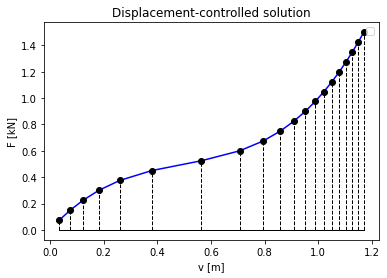

In [14]:
#k = 0.
fig, ax = plt.subplots()
nstep = 20
ydata = [(i+1)*F/nstep for i in range(nstep)]
xdata = []
v = 0
for Fi in ydata:
    v = minimize(TPE(Fi), [v], method='Nelder-Mead', tol=1e-8).x[0]
    xdata.append(v)
ax.plot(xdata, ydata, color='b')    
markerline, stemlines, baseline = \
    ax.stem(xdata, ydata, basefmt='k-', markerfmt='ko', linefmt='k--')
plt.setp(stemlines, 'linewidth', 1)
plt.setp(baseline, 'linewidth', 1)
ax.set_xlabel('v [m]')
ax.set_ylabel('F [kN]')
ax.legend()
ax.set_title('Displacement-controlled solution')
plt.show()